## Now Training Multiple Models and Comparing Performance Using PyCaret
- GitHub link: https://github.com/pycaret/pycaret
- Documentation and tutorials also found on the GitHub

In [1]:
import pycaret
from pycaret.classification import *
import pandas as pd
pycaret.__version__

'3.3.2'

In [2]:
# load in data 
train_data = pd.read_csv("../motum/data_for_pycaret_train.csv")
test_data = pd.read_csv("../motum/data_for_pycaret_test.csv")
print(train_data.shape)
print(test_data.shape)

# initializing pycaret setup
s = setup(
    data=train_data,
    test_data=test_data,            
    target="label",
    session_id=42,
    fold_strategy="groupkfold",     # we are doing a group-aware cross validation
    fold_groups="subject_id",     
    ignore_features=["subject_id"], # keep for grouping, not modeling
    fold=5, # number of CV folds
    index=False,
    normalize=True,
    normalize_method='zscore'
)

(51, 12)
(13, 12)


,Description,Value
0,Session id,42
1,Target,label
2,Target type,Binary
3,Target mapping,"glioma: 0, metastasis: 1"
4,Original data shape,"(64, 12)"
5,Transformed data shape,"(64, 11)"
6,Transformed train set shape,"(51, 11)"
7,Transformed test set shape,"(13, 11)"
8,Ignore features,1
9,Numeric features,10


In [3]:
# initiating classification experiment class
exp = ClassificationExperiment()
type(exp)

# initiating setup on exp
exp.setup(
    data=train_data,
    test_data=test_data,            
    target="label",
    session_id=42,
    fold_strategy="groupkfold",     # we are doing a group-aware cross validation
    fold_groups="subject_id",     
    ignore_features=["subject_id"], # keep for grouping, not modeling
    fold=5, # number of CV folds
    index=False,
    normalize=True,
    normalize_method='zscore'
)

,Description,Value
0,Session id,42
1,Target,label
2,Target type,Binary
3,Target mapping,"glioma: 0, metastasis: 1"
4,Original data shape,"(64, 12)"
5,Transformed data shape,"(64, 11)"
6,Transformed train set shape,"(51, 11)"
7,Transformed test set shape,"(13, 11)"
8,Ignore features,1
9,Numeric features,10


In [4]:
# comparing these basline models now
best = compare_models(probability_threshold = 0.5, turbo=False, n_select=-1)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.7455,0.7667,0.7455,0.7920,0.7313,0.4703,0.5166,0.2680
lda,Linear Discriminant Analysis,0.7455,0.7643,0.7455,0.8007,0.7384,0.4931,0.5368,0.0080
knn,K Neighbors Classifier,0.7436,0.8392,0.7436,0.7686,0.7388,0.4698,0.4946,0.2560
rbfsvm,SVM - Radial Kernel,0.7436,0.7773,0.7436,0.7827,0.7329,0.4589,0.5031,0.0080
rf,Random Forest Classifier,0.7418,0.8025,0.7418,0.7742,0.7322,0.4701,0.5003,0.0380
lightgbm,Light Gradient Boosting Machine,0.7291,0.7313,0.7291,0.7494,0.7263,0.4492,0.4671,0.0340
lr,Logistic Regression,0.7273,0.7587,0.7273,0.7445,0.7162,0.4295,0.4509,0.5280
ridge,Ridge Classifier,0.7255,0.7643,0.7255,0.7767,0.7178,0.4464,0.4885,0.0120
gpc,Gaussian Process Classifier,0.7036,0.7433,0.7036,0.7361,0.7015,0.4098,0.4308,0.0160
et,Extra Trees Classifier,0.7018,0.8133,0.7018,0.7468,0.6947,0.4004,0.4356,0.0360


In [5]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [6]:
# SGD 
sgd = create_model('svm') # actually SGD - good for larger datasets but ours is small

params_sgd = {
    'alpha': [1e-5, 0.0001, 0.001, 0.01, 0.1],
    'penalty': ['l2', 'l1', 'elasticnet']
}

# tune with custom grid
tuned_sgd = tune_model(sgd, custom_grid=params_sgd, n_iter=100)

# get all hyperparameters of the best model
best_params = tuned_sgd.get_params()
print(best_params)

# for param in params_sgd.keys():
#     val = best_params[param]
#     print(f"Best {param}: {val}")

print("Best parameters:")
final_sgd_params = {param: best_params[param] for param in params_sgd.keys()}
print(final_sgd_params)

# save the mean accuracy, AUC, recall, precision, and F1 score
sgd_results_df = pull()
sgd_mean_metrics = sgd_results_df.loc['Mean']

evaluate_model(tuned_sgd)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7273,0.8667,0.7273,0.8182,0.6961,0.4211,0.5164
1,0.7000,0.8000,0.7000,0.8125,0.6703,0.4000,0.5000
2,0.7000,0.6667,0.7000,0.7200,0.7030,0.4000,0.4082
3,0.7000,0.5833,0.7000,0.6952,0.6901,0.3478,0.3563
4,0.9000,0.9167,0.9000,0.9143,0.8967,0.7826,0.8018
Mean,0.7455,0.7667,0.7455,0.7920,0.7313,0.4703,0.5166
Std,0.0780,0.1243,0.0780,0.0782,0.0834,0.1580,0.1543


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7273,0.8667,0.7273,0.8182,0.6961,0.4211,0.5164
1,0.9000,0.9600,0.9000,0.9167,0.8990,0.8000,0.8165
2,0.7000,0.6667,0.7000,0.7200,0.7030,0.4000,0.4082
3,0.7000,0.5833,0.7000,0.6952,0.6901,0.3478,0.3563
4,0.8000,0.9583,0.8000,0.8667,0.8000,0.6154,0.6667
Mean,0.7655,0.8070,0.7655,0.8034,0.7576,0.5169,0.5528
Std,0.0766,0.1547,0.0766,0.0845,0.0814,0.1681,0.1693


Fitting 5 folds for each of 15 candidates, totalling 75 fits
{'alpha': 0.01, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.001, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': 1000, 'n_iter_no_change': 5, 'n_jobs': -1, 'penalty': 'elasticnet', 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Best parameters:
{'alpha': 0.01, 'penalty': 'elasticnet'}


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [7]:
# RBF SVM
## ROUND 1
rbf_svm = create_model('rbfsvm')

params_rbf_svm = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'class_weight': [None, 'balanced']
}

# tune with custom grid
tuned_rbf_svm = tune_model(rbf_svm, custom_grid=params_rbf_svm, n_iter=100)

# get all hyperparameters of the best model
best_params = tuned_rbf_svm.get_params()
print(best_params)

for param in params_rbf_svm.keys():
    val = best_params[param]
    print(f"Best {param}: {val}")

## ROUND 2
# making RBF-SVM model and tuning hyperparameters
rbf_svm2 = create_model('rbfsvm')

params_rbf_svm2 = {
    'C': [50, 75, 100, 150, 200, 500], # harsher boruta requires higher C but higher risk of overfitting
    'gamma': [0.0005, 0.00075, 0.001, 0.0025, 0.005, 0.0075], # controls how tightly each training point influences the decision boundary.
    'class_weight': [None, 'balanced'],
    "max_iter": [500, 1000, 3000, 10000]
}

# tune with custom grid
tuned_rbf_svm2 = tune_model(rbf_svm2, custom_grid=params_rbf_svm2, n_iter=100)

# get all hyperparameters of the best model
best_params = tuned_rbf_svm2.get_params()
print(best_params)

# accessing specific hyperparameters
print("Best parameters:")
final_rbf_svm2_params = {param: best_params[param] for param in params_rbf_svm2.keys()}
print(final_rbf_svm2_params)

# save the mean accuracy, AUC, recall, precision, and F1 score
rbf_svm_results_df = pull()
rbf_svm_mean_metrics = rbf_svm_results_df.loc['Mean']

evaluate_model(tuned_rbf_svm2)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8182,0.8000,0.8182,0.8636,0.8084,0.6207,0.6708
1,0.8000,0.9200,0.8000,0.8571,0.7917,0.6000,0.6547
2,0.8000,0.7917,0.8000,0.8500,0.7810,0.5455,0.6124
3,0.4000,0.3750,0.4000,0.4000,0.4000,-0.2500,-0.2500
4,0.8000,1.0000,0.8000,0.8667,0.8000,0.6154,0.6667
Mean,0.7236,0.7773,0.7236,0.7675,0.7162,0.4263,0.4709
Std,0.1620,0.2157,0.1620,0.1838,0.1584,0.3392,0.3610


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7273,0.7667,0.7273,0.8182,0.6961,0.4211,0.5164
1,0.8000,0.9200,0.8000,0.8571,0.7917,0.6000,0.6547
2,0.7000,0.6667,0.7000,0.7200,0.7030,0.4000,0.4082
3,0.6000,0.5833,0.6000,0.5750,0.5619,0.0909,0.1021
4,0.9000,0.9583,0.9000,0.9200,0.9010,0.8000,0.8165
Mean,0.7455,0.7790,0.7455,0.7781,0.7307,0.4624,0.4996
Std,0.1004,0.1436,0.1004,0.1205,0.1124,0.2352,0.2413


Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'C': 100, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.001, 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Best C: 100
Best gamma: 0.001
Best class_weight: None


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8182,0.8000,0.8182,0.8636,0.8084,0.6207,0.6708
1,0.8000,0.9200,0.8000,0.8571,0.7917,0.6000,0.6547
2,0.8000,0.7917,0.8000,0.8500,0.7810,0.5455,0.6124
3,0.4000,0.3750,0.4000,0.4000,0.4000,-0.2500,-0.2500
4,0.8000,1.0000,0.8000,0.8667,0.8000,0.6154,0.6667
Mean,0.7236,0.7773,0.7236,0.7675,0.7162,0.4263,0.4709
Std,0.1620,0.2157,0.1620,0.1838,0.1584,0.3392,0.3610


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7273,0.8333,0.7273,0.8182,0.6961,0.4211,0.5164
1,0.9000,0.9600,0.9000,0.9167,0.8990,0.8000,0.8165
2,0.7000,0.6667,0.7000,0.7200,0.7030,0.4000,0.4082
3,0.6000,0.5833,0.6000,0.5750,0.5619,0.0909,0.1021
4,0.9000,0.9583,0.9000,0.9143,0.8967,0.7826,0.8018
Mean,0.7655,0.8003,0.7655,0.7888,0.7513,0.4989,0.5290
Std,0.1177,0.1526,0.1177,0.1292,0.1298,0.2659,0.2661


Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'C': 75, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.00075, 'kernel': 'rbf', 'max_iter': 500, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Best parameters:
{'C': 75, 'gamma': 0.00075, 'class_weight': None, 'max_iter': 500}


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [8]:
from sklearn.svm import SVC
svm_linear = create_model(SVC(kernel="linear", probability=True))
params_svml = {
    "C": [0.01, 0.1, 1, 10, 100],# reg param
    # "penalty": ["l2", "l1"] # l2 is standard for cvm according to sklearn
}

tuned_svm_linear = tune_model(svm_linear, custom_grid=params_svml, n_iter=100)
best_params = tuned_svm_linear.get_params()
print(best_params)

print("Best parameters:")
final_svml_params = {param: best_params[param] for param in params_svml.keys()}
print(final_svml_params)

evaluate_model(tuned_svm_linear)

# save the mean accuracy, AUC, recall, precision, and F1 score
svml_results_df = pull()
svml_mean_metrics = svml_results_df.loc['Mean']

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6364,0.7000,0.6364,0.6439,0.6169,0.2414,0.2609
1,0.8000,0.9600,0.8000,0.8571,0.7917,0.6000,0.6547
2,0.7000,0.6667,0.7000,0.7200,0.7030,0.4000,0.4082
3,0.6000,0.5833,0.6000,0.5750,0.5619,0.0909,0.1021
4,0.8000,0.9583,0.8000,0.8667,0.8000,0.6154,0.6667
Mean,0.7073,0.7737,0.7073,0.7325,0.6947,0.3895,0.4185
Std,0.0822,0.1562,0.0822,0.1152,0.0941,0.2032,0.2202


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7273,0.8333,0.7273,0.8182,0.6961,0.4211,0.5164
1,0.9000,0.9200,0.9000,0.9167,0.8990,0.8000,0.8165
2,0.7000,0.6667,0.7000,0.7200,0.7030,0.4000,0.4082
3,0.6000,0.5833,0.6000,0.5750,0.5619,0.0909,0.1021
4,0.9000,0.9583,0.9000,0.9143,0.8967,0.7826,0.8018
Mean,0.7655,0.7923,0.7655,0.7888,0.7513,0.4989,0.5290
Std,0.1177,0.1449,0.1177,0.1292,0.1298,0.2659,0.2661


Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'C': 0.1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Best parameters:
{'C': 0.1}


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [9]:
# Linear discriminant analysis
lda = create_model('lda')

params_lda = {
    "solver": ["svd", "lsqr", "eigen"],
    "shrinkage": [None, "auto", 0.0, 0.1, 0.2, 0.3, 0.5]  # only used for lsqr/eigen
}

# tune with custom grid
tuned_lda = tune_model(lda, custom_grid=params_lda, n_iter=100)

# get all hyperparameters of the best model
best_params = tuned_lda.get_params()
print(best_params)

print("Best parameters:")
final_lda_params = {param: best_params[param] for param in params_lda.keys()}
print(final_lda_params)

evaluate_model(tuned_lda)

# save the mean accuracy, AUC, recall, precision, and F1 score
lda_results_df = pull()
lda_mean_metrics = lda_results_df.loc['Mean']

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7273,0.7333,0.7273,0.8182,0.6961,0.4211,0.5164
1,0.9000,0.8800,0.9000,0.9167,0.8990,0.8000,0.8165
2,0.7000,0.6250,0.7000,0.7200,0.7030,0.4000,0.4082
3,0.7000,0.6250,0.7000,0.7200,0.7030,0.4000,0.4082
4,0.7000,0.9583,0.7000,0.8286,0.6909,0.4444,0.5345
Mean,0.7455,0.7643,0.7455,0.8007,0.7384,0.4931,0.5368
Std,0.0780,0.1348,0.0780,0.0742,0.0804,0.1543,0.1495


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7273,0.7333,0.7273,0.8182,0.6961,0.4211,0.5164
1,0.9000,0.8800,0.9000,0.9167,0.8990,0.8000,0.8165
2,0.7000,0.6250,0.7000,0.7200,0.7030,0.4000,0.4082
3,0.7000,0.6250,0.7000,0.7200,0.7030,0.4000,0.4082
4,0.7000,0.9583,0.7000,0.8286,0.6909,0.4444,0.5345
Mean,0.7455,0.7643,0.7455,0.8007,0.7384,0.4931,0.5368
Std,0.0780,0.1348,0.0780,0.0742,0.0804,0.1543,0.1495


Fitting 5 folds for each of 21 candidates, totalling 105 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
{'covariance_estimator': None, 'n_components': None, 'priors': None, 'shrinkage': None, 'solver': 'svd', 'store_covariance': False, 'tol': 0.0001}
Best parameters:
{'solver': 'svd', 'shrinkage': None}


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
# KNN
# making RBF-SVM model and tuning hyperparameters
knn = create_model('knn')

params_knn = {
    "n_neighbors": [5, 7, 9, 11, 15, 21, 31],
    "weights": ["distance", "uniform"],
    "metric": ["manhattan", "euclidean"],
    "p": [1, 2]
}

# tune with custom grid
tuned_knn = tune_model(knn, custom_grid=params_knn, n_iter=100)

# get all hyperparameters of the best model
best_params = tuned_knn.get_params()
print(best_params)

print("Best parameters:")
final_knn_params = {param: best_params[param] for param in params_knn.keys()}
print(final_knn_params)

evaluate_model(tuned_knn)

# save the mean accuracy, AUC, recall, precision, and F1 score
knn_results_df = pull()
knn_mean_metrics = knn_results_df.loc['Mean']

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8182,0.9000,0.8182,0.8636,0.8084,0.6207,0.6708
1,0.9000,0.9000,0.9000,0.9167,0.8990,0.8000,0.8165
2,0.7000,0.8333,0.7000,0.7200,0.7030,0.4000,0.4082
3,0.5000,0.6042,0.5000,0.4762,0.4835,-0.0870,-0.0891
4,0.8000,0.9583,0.8000,0.8667,0.8000,0.6154,0.6667
Mean,0.7436,0.8392,0.7436,0.7686,0.7388,0.4698,0.4946
Std,0.1374,0.1240,0.1374,0.1603,0.1419,0.3059,0.3201


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9091,0.9333,0.9091,0.9221,0.9075,0.8136,0.8281
1,0.9000,0.8400,0.9000,0.9167,0.8990,0.8000,0.8165
2,0.8000,0.7917,0.8000,0.8000,0.8000,0.5833,0.5833
3,0.6000,0.5833,0.6000,0.5750,0.5619,0.0909,0.1021
4,0.8000,0.9583,0.8000,0.8667,0.8000,0.6154,0.6667
Mean,0.8018,0.8213,0.8018,0.8161,0.7937,0.5806,0.5993
Std,0.1113,0.1336,0.1113,0.1283,0.1248,0.2621,0.2652


Fitting 5 folds for each of 56 candidates, totalling 280 fits
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'manhattan', 'metric_params': None, 'n_jobs': -1, 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Best parameters:
{'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'p': 1}


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

# Other models used in literature

In [11]:
## ROUND 1
# making lasso model and tuning hyperparameters
lasso_clf = create_model('lr', penalty='l1', solver='liblinear')

# Define custom grid for L1 logistic regression hyperparameters
params_lasso = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # Inverse regularization strength
    "max_iter": [1000, 3000, 5000],  # Maximum iterations
    "class_weight": [None, 'balanced']
}

# Or use random search with n_iter
tuned_lasso_clf = tune_model(lasso_clf, custom_grid=params_lasso, n_iter=100)

# get all hyperparameters of the best model
best_params = tuned_lasso_clf.get_params()
print(best_params)

for param in params_lasso.keys():
    val = best_params[param]
    print(f"Best {param}: {val}")

## ROUND 2
# making lasso model and tuning hyperparameters
lasso_clf2 = create_model('lr', penalty='l1', solver='liblinear')

# using more granular hyperparameters
params_lasso = {
    "C": [0.4, 0.6, 0.8, 1, 3, 5, 7],     # Inverse regularization strength
    "max_iter": [1000, 3000, 5000],          # Maximum iterations
    "class_weight": [None, 'balanced']
}

# Or use random search with n_iter
tuned_lasso_clf2 = tune_model(lasso_clf2, custom_grid=params_lasso, n_iter=100)

# get all hyperparameters of the best model
best_params2 = tuned_lasso_clf2.get_params()
print(best_params2)

print("Best parameters:")
final_lasso_params = {param: best_params[param] for param in params_lasso.keys()}
print(final_lasso_params)

# save the mean accuracy, AUC, recall, precision, and F1 score
lasso_results_df = pull()
lasso_mean_metrics = lasso_results_df.loc['Mean']
evaluate_model(tuned_lasso_clf2)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6364,0.8667,0.6364,0.6439,0.6169,0.2414,0.2609
1,0.9000,0.9200,0.9000,0.9167,0.8990,0.8000,0.8165
2,0.7000,0.5833,0.7000,0.7200,0.7030,0.4000,0.4082
3,0.6000,0.5000,0.6000,0.6000,0.6000,0.1667,0.1667
4,0.8000,0.9583,0.8000,0.8667,0.8000,0.6154,0.6667
Mean,0.7273,0.7657,0.7273,0.7495,0.7238,0.4447,0.4638
Std,0.1098,0.1871,0.1098,0.1233,0.1129,0.2350,0.2442


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7273,0.8000,0.7273,0.7305,0.7226,0.4407,0.4485
1,0.9000,0.9600,0.9000,0.9167,0.8990,0.8000,0.8165
2,0.7000,0.6250,0.7000,0.7200,0.7030,0.4000,0.4082
3,0.8000,0.6250,0.8000,0.8000,0.8000,0.5833,0.5833
4,0.8000,0.9167,0.8000,0.8667,0.8000,0.6154,0.6667
Mean,0.7855,0.7853,0.7855,0.8068,0.7849,0.5679,0.5847
Std,0.0696,0.1410,0.0696,0.0762,0.0694,0.1419,0.1484


Fitting 5 folds for each of 42 candidates, totalling 210 fits
{'C': 10, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Best C: 10
Best max_iter: 1000
Best class_weight: balanced


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6364,0.8667,0.6364,0.6439,0.6169,0.2414,0.2609
1,0.9000,0.9200,0.9000,0.9167,0.8990,0.8000,0.8165
2,0.7000,0.5833,0.7000,0.7200,0.7030,0.4000,0.4082
3,0.6000,0.5000,0.6000,0.6000,0.6000,0.1667,0.1667
4,0.8000,0.9583,0.8000,0.8667,0.8000,0.6154,0.6667
Mean,0.7273,0.7657,0.7273,0.7495,0.7238,0.4447,0.4638
Std,0.1098,0.1871,0.1098,0.1233,0.1129,0.2350,0.2442


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6364,0.8000,0.6364,0.6439,0.6169,0.2414,0.2609
1,0.9000,0.9600,0.9000,0.9167,0.8990,0.8000,0.8165
2,0.7000,0.6250,0.7000,0.7200,0.7030,0.4000,0.4082
3,0.7000,0.5833,0.7000,0.6952,0.6901,0.3478,0.3563
4,0.8000,0.9167,0.8000,0.8667,0.8000,0.6154,0.6667
Mean,0.7473,0.7770,0.7473,0.7685,0.7418,0.4809,0.5017
Std,0.0926,0.1511,0.0926,0.1047,0.0979,0.2008,0.2070


Fitting 5 folds for each of 42 candidates, totalling 210 fits
{'C': 5, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Best parameters:
{'C': 10, 'max_iter': 1000, 'class_weight': 'balanced'}


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
## Ada just for comparison since top for initial analysis
ada_clf = create_model('ada')

ada_params = {
    "n_estimators": [30, 50, 100, 150, 200],
    "learning_rate": [0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0],
}

# tuning the model
tuned_ada_clf = tune_model(ada_clf, custom_grid=ada_params, n_iter=100)

# get all hyperparameters of the best model
best_params = tuned_ada_clf.get_params()
print(best_params)

# accessing specific hyperparameters
print("Best parameters:")
final_ada_params = {param: best_params[param] for param in ada_params.keys()}
print(final_ada_params)

# save the mean accuracy, AUC, recall, precision, and F1 score
ada_results_df = pull()
ada_mean_metrics = ada_results_df.loc['Mean']
evaluate_model(tuned_ada_clf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7273,0.7333,0.7273,0.7394,0.7273,0.4590,0.4667
1,0.5000,0.6200,0.5000,0.5000,0.4505,0.0000,0.0000
2,0.6000,0.8333,0.6000,0.6500,0.6000,0.2308,0.2500
3,0.7000,0.9167,0.7000,0.6952,0.6901,0.3478,0.3563
4,0.8000,0.7500,0.8000,0.8667,0.8000,0.6154,0.6667
Mean,0.6655,0.7707,0.6655,0.6903,0.6536,0.3306,0.3479
Std,0.1047,0.0998,0.1047,0.1195,0.1202,0.2084,0.2220


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8182,0.8000,0.8182,0.8182,0.8182,0.6333,0.6333
1,0.6000,0.7000,0.6000,0.6190,0.5833,0.2000,0.2182
2,0.7000,0.7917,0.7000,0.8286,0.6909,0.4444,0.5345
3,0.8000,0.9167,0.8000,0.8500,0.7810,0.5455,0.6124
4,0.8000,0.8750,0.8000,0.8667,0.8000,0.6154,0.6667
Mean,0.7436,0.8167,0.7436,0.7965,0.7347,0.4877,0.5330
Std,0.0830,0.0747,0.0830,0.0903,0.0874,0.1584,0.1633


Fitting 5 folds for each of 35 candidates, totalling 175 fits
{'algorithm': 'SAMME.R', 'estimator': None, 'learning_rate': 0.5, 'n_estimators': 30, 'random_state': 42}
Best parameters:
{'n_estimators': 30, 'learning_rate': 0.5}


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

#### Now improving ease of comparison of models with each other

In [13]:
# Comparing accuracy, AUC, recall, precision, and F1 score between the three optimized models based on k-fold cross validation
comparison_df = pd.DataFrame([
    sgd_mean_metrics,
    rbf_svm_mean_metrics,
    svml_mean_metrics,
    lda_mean_metrics,
    knn_mean_metrics,
    lasso_mean_metrics,
    ada_mean_metrics
], index=['SGD', 'RBF SVM', 'SVM Linear', 'LDA', 'KNN', 'LASSO','ADA'])

# Selecting for accruacy, AUC, recall, precision, and F1 score and printing result for ease of comparison
metrics = ['Accuracy', 'AUC', 'Recall', 'Prec.', 'F1']
print(comparison_df[metrics])

            Accuracy     AUC  Recall   Prec.      F1
SGD           0.7655  0.8070  0.7655  0.8034  0.7576
RBF SVM       0.7655  0.8003  0.7655  0.7888  0.7513
SVM Linear    0.7655  0.7923  0.7655  0.7888  0.7513
LDA           0.7455  0.7643  0.7455  0.8007  0.7384
KNN           0.8018  0.8213  0.8018  0.8161  0.7937
LASSO         0.7473  0.7770  0.7473  0.7685  0.7418
ADA           0.7436  0.8167  0.7436  0.7965  0.7347


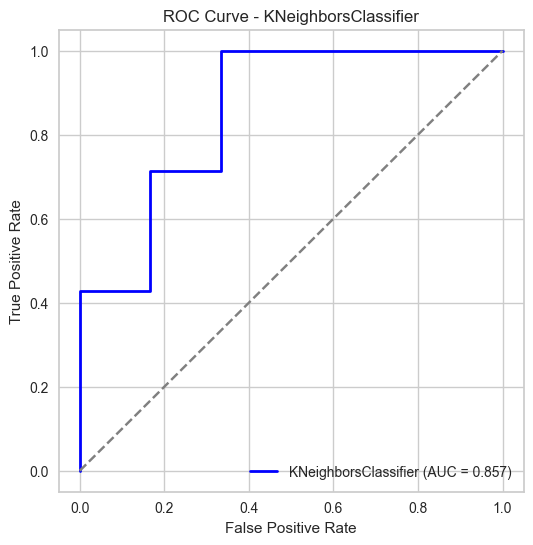

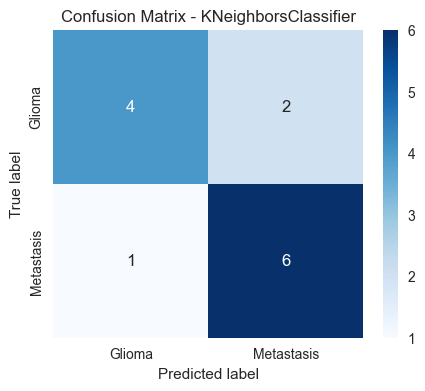

KNeighborsClassifier
Accuracy:  0.769
AUC:      0.857
Precision: 0.750
Recall:    0.857
F1 score:  0.800


In [14]:
# train best classifier on full dataset with best params
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
# from sklearn.model_selection import learning_curve, GroupKFold
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


## KNN
final_knn = KNeighborsClassifier(**final_knn_params)

# preparing X_train, X_test, y_train, and y_test, train_data and test_data were defined earlier in this notebook
# first removing subject_id column, not useful feature
train_data_noid = train_data.drop(columns=['subject_id'])
test_data_noid = test_data.drop(columns=['subject_id'])

# assign target variable to y and remove from X
X_train = train_data_noid.drop(columns=['label'])
y_train = train_data_noid['label']

X_test = test_data_noid.drop(columns=['label'])
y_test = test_data_noid['label']

# convert y_test and y_train to numeric (glioma: 0, metastasis: 1)
label_map = {'glioma': 0, 'metastasis': 1}
y_train = y_train.map(label_map)
y_test = y_test.map(label_map)

# perform z-score standardization only on X, though this is most likely unnecessary for decision trees
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## train models on the entire training set
def plot_pred(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)[:, 1]

    # get model name
    model_type = type(model)
    model_name = model_type.__name__

    # get test performance
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    # plot ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
    roc_auc = auc(fpr, tpr)

    roc_df = pd.DataFrame({
    "fpr": fpr,
    "tpr": tpr,
    "thresholds": thresholds
    })

    roc_df.to_csv("KNN_roc_curve_data.csv", index=False)

    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})')
    plt.plot([0,1], [0,1], color='grey', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.show()

    # plot confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=['Glioma', 'Metastasis'],
                yticklabels=['Glioma', 'Metastasis'])
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    print(model_name)
    print(f"Accuracy:  {accuracy:.3f}")
    print(f"AUC:      {roc_auc:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"F1 score:  {f1:.3f}")


plot_pred(final_knn, X_train_scaled, X_test_scaled, y_train, y_test)


                                        feature  importance_mean  \
0                    gldm_DependenceVariance_t1         0.061765   
1                          shape_Flatness_flair         0.054902   
2              shape_Maximum2DDiameterRow_flair         0.036275   
3                    glcm_InverseVariance_flair         0.036275   
4  gldm_DependenceNonUniformityNormalized_flair         0.036275   
5                             ngtdm_Strength_t2         0.033333   
6                     firstorder_Skewness_flair         0.030392   
7                     firstorder_Kurtosis_flair         0.029412   
8                         firstorder_Maximum_t1         0.025490   
9                 gldm_DependenceVariance_flair         0.017647   

   importance_std  
0        0.016724  
1        0.032575  
2        0.019876  
3        0.016724  
4        0.018884  
5        0.019706  
6        0.013117  
7        0.022782  
8        0.016522  
9        0.012245  


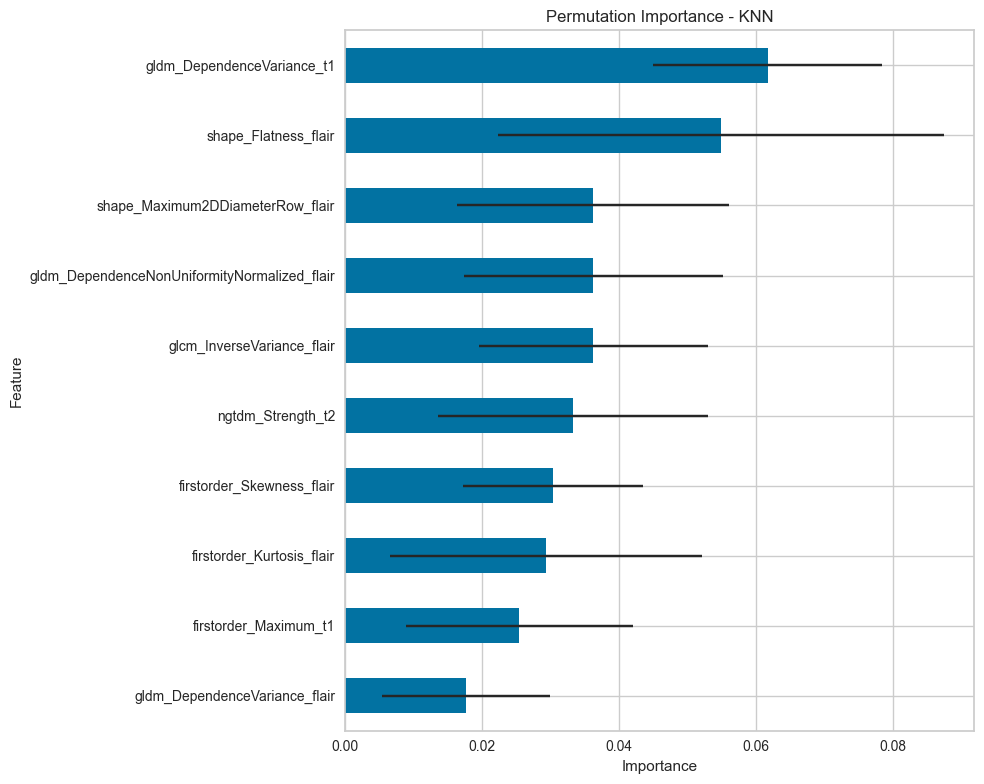

In [15]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
f_names = X_train_scaled_df.columns

result = permutation_importance(final_knn, X_train_scaled_df, y_train, 
                                n_repeats=20, 
                                random_state=42,
                                n_jobs=-1)
imp = pd.Series(result.importances_mean, index=f_names)
std = pd.Series(result.importances_std, index=f_names)

imp_sorted = imp.sort_values(ascending=True)
std_sorted = std.loc[imp_sorted.index].values

# convert to df and order
fi_df = pd.DataFrame({
    "feature": f_names,
    "importance_mean": result.importances_mean, # qunatifies mean drop in accuracy with 20 permutations 
    "importance_std": result.importances_std
})
fi_df = fi_df.sort_values(by="importance_mean", ascending=False)
fi_df = fi_df.reset_index(drop=True)
print(fi_df)

# plot feature importance
fig, ax = plt.subplots(figsize=(10, 8))
imp_sorted.plot.barh(xerr=std_sorted, ax=ax)
ax.set_title("Permutation Importance - KNN")
ax.set_xlabel("Importance")
ax.set_ylabel("Feature")
plt.tight_layout()
fi_df.to_csv("perm_importance_knn.csv", index=False)
